In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

%matplotlib inline
#from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
from PIL import Image
from tensorboardX import SummaryWriter
from datetime import datetime
import utils.train_utils as ft

plt.ion()   # interactive mode

Load Data
---------



In [2]:
# Data augmentation and normalization for training 
# Just normalization for validation
batch_size=32

data_transforms = {
    'train': transforms.Compose([
        transforms.Scale(256),
        transforms.RandomCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        #ts_transforms.RandomRotate(30)
    ]),
    'test': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

'''Change it with the directory of the CIR dataset'''
data_dir = '/home/mtezcan/Desktop/CIR-APP/Dataset'
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
         for x in ['train', 'test']}
dsets_real = dsets
    

sampler = {'train':None,
           'test':None}

shuffler={'train':True,'test':False}
dset_loaders = {x:torch.utils.data.DataLoader(dsets[x], batch_size=batch_size,shuffle=shuffler[x],
                                              sampler=sampler[x], num_workers=12)
                for x in ['train','test']}
dset_sizes = {x: len(dsets[x]) for x in ['train', 'test']}
dset_classes = dsets['train'].classes
print(dset_classes)
use_gpu = torch.cuda.is_available()

dset_loaders_real=dset_loaders
dset_sizes_real=dset_sizes

if use_gpu:
    print('GPU is available')
else:
    print('!!!!! NO CUDA GPUS DETECTED')

['CIR 1', 'CIR 2', 'CIR 3', 'CIR 4', 'CIR 5', 'CIR 6', 'CIR 7', 'CIR 8', 'CIR 9']
GPU is available


/home/mtezcan/anaconda3/envs/hoarding/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


Visualize a few images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Size of the input tensors in one batch after grid is  torch.Size([3, 1810, 906])


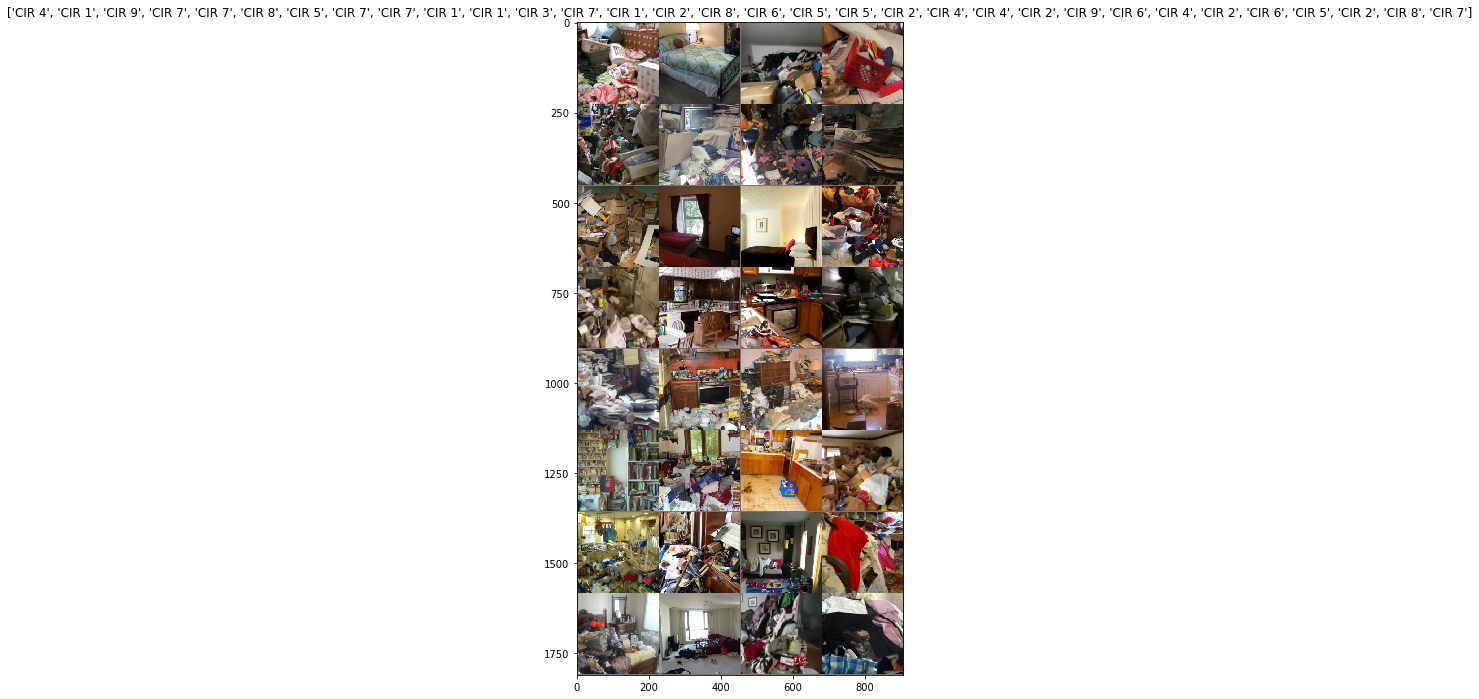

In [3]:

inputs, classes = next(iter(dset_loaders['train']))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs,nrow=4)
print('Size of the input tensors in one batch after grid is  '+str(out.size()))
plt.figure(figsize=(12,12))
ft.imshow(out, title=[dset_classes[x] for x in classes])

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [4]:
network='resnet18'
networkName='CIRApp'
optimizer='sgd'
lr=0.01
momentum=0.9
weight_decay=0.0005
lr_scheduler=ft.exp_lr_scheduler
lr_decay_epoch=10
pretrained=True
dataset='hoarding'

if(dataset=='mit_indoor'):
    nclasses=67
else:
    nclasses=9

model_ft = models.resnet18(pretrained=pretrained)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, nclasses)
        
if use_gpu:
    model_ft = model_ft.cuda()


if(optimizer=='adam'):
    optimizer_ft = optim.Adam(model_ft.parameters(),lr=lr,weight_decay=weight_decay)
elif(optimizer=='sgd'):
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=lr, momentum=momentum,weight_decay=weight_decay)

In [5]:
import importlib
importlib.reload(ft)
data_name=dataset
    
logname=network+'_'+data_name+'_'+optimizer+'_'+datetime.now().strftime('%B%d  %H:%M:%S')
writer = SummaryWriter('runs/'+logname)

model_ft = ft.train_model(model_ft, optimizer_ft, lr_scheduler,dset_loaders,dset_sizes,writer,
                    use_gpu=use_gpu,num_epochs=50,batch_size=batch_size,num_log=10,
                    lr_decay_epoch=lr_decay_epoch,init_lr=lr,lmbda=0.9)


Epoch 0/49
----------
LR is set to 0.01


/home/mtezcan/Documents/projects/Hoarding-pytorch/utils/train_utils.py:102: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  running_loss += loss.data[0].cpu().numpy()


10/39, CCR: 0.1156, CCR-1: 0.3594
20/39, CCR: 0.1531, CCR-1: 0.4469
30/39, CCR: 0.1958, CCR-1: 0.5281
train Loss: 0.0215 CCR: 0.2247 CCR-1: 0.5815
test Loss: 0.0188 CCR: 0.3333 CCR-1: 0.6778

Epoch 1/49
----------
10/39, CCR: 0.3187, CCR-1: 0.6500
20/39, CCR: 0.3469, CCR-1: 0.7203
30/39, CCR: 0.3594, CCR-1: 0.7427
train Loss: 0.0161 CCR: 0.3804 CCR-1: 0.7729
test Loss: 0.0176 CCR: 0.3556 CCR-1: 0.6889

Epoch 2/49
----------
10/39, CCR: 0.4094, CCR-1: 0.7500
20/39, CCR: 0.4156, CCR-1: 0.7781
30/39, CCR: 0.4344, CCR-1: 0.8000
train Loss: 0.0140 CCR: 0.4680 CCR-1: 0.8297
test Loss: 0.0169 CCR: 0.3889 CCR-1: 0.6778

Epoch 3/49
----------
10/39, CCR: 0.4688, CCR-1: 0.7844
20/39, CCR: 0.4953, CCR-1: 0.8344
30/39, CCR: 0.5010, CCR-1: 0.8427
train Loss: 0.0128 CCR: 0.5118 CCR-1: 0.8662
test Loss: 0.0204 CCR: 0.3889 CCR-1: 0.6556

Epoch 4/49
----------
10/39, CCR: 0.5156, CCR-1: 0.7969
20/39, CCR: 0.5437, CCR-1: 0.8656
30/39, CCR: 0.5500, CCR-1: 0.8792
train Loss: 0.0117 CCR: 0.5620 CCR-1: 0.90

10/39, CCR: 0.7906, CCR-1: 0.8906
20/39, CCR: 0.8344, CCR-1: 0.9437
30/39, CCR: 0.8469, CCR-1: 0.9583
train Loss: 0.0043 CCR: 0.8816 CCR-1: 0.9911
test Loss: 0.0207 CCR: 0.5222 CCR-1: 0.7889

Epoch 39/49
----------
10/39, CCR: 0.8375, CCR-1: 0.9000
20/39, CCR: 0.8438, CCR-1: 0.9500
30/39, CCR: 0.8604, CCR-1: 0.9656
train Loss: 0.0038 CCR: 0.8913 CCR-1: 0.9984
test Loss: 0.0208 CCR: 0.5000 CCR-1: 0.8000

Epoch 40/49
----------
LR is set to 1.0000000000000002e-06
10/39, CCR: 0.7688, CCR-1: 0.8906
20/39, CCR: 0.8266, CCR-1: 0.9406
30/39, CCR: 0.8427, CCR-1: 0.9594
train Loss: 0.0042 CCR: 0.8702 CCR-1: 0.9911
test Loss: 0.0204 CCR: 0.5000 CCR-1: 0.8000

Epoch 41/49
----------
10/39, CCR: 0.8281, CCR-1: 0.8969
20/39, CCR: 0.8766, CCR-1: 0.9484
30/39, CCR: 0.8844, CCR-1: 0.9646
train Loss: 0.0034 CCR: 0.9197 CCR-1: 0.9968
test Loss: 0.0208 CCR: 0.5111 CCR-1: 0.8000

Epoch 42/49
----------
10/39, CCR: 0.8156, CCR-1: 0.9000
20/39, CCR: 0.8578, CCR-1: 0.9484
30/39, CCR: 0.8760, CCR-1: 0.9656
tr

In [6]:
torch.save(model_ft,'./CIR_estimator.mdl')
model_ft_backup=model_ft

In [4]:
from PIL import Image
import torchvision.transforms.functional as TF
from torch import load as tload
from torch import max as tmax
from torchvision.transforms import Scale, CenterCrop, ToTensor, Normalize
from torch.autograd import Variable

# Paths
model_path = './CIR_estimator.mdl'
image_path = './example_images/CIR9_example.jpg'

# Load the model
cir_est=tload(model_path).cpu()
cir_est.train(False)

# Load the image
image = Image.open(image_path)
image = Scale(256)(image)
image = CenterCrop(224)(image)
image = ToTensor()(image)
image = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])(image)
image.unsqueeze_(0)

# Calculate the CIR pestimation
_, cir_score = tmax(cir_est(Variable(image)).data, 1)
cir_score = cir_score.numpy()[0]+1
print('Estimated CIR score is %d' %cir_score)

Estimated CIR score is 7


In [11]:
#Trials
model_ft=torch.load('./CIR_estimator')
model_ft.train(False)
running_cir1=0
for data in dset_loaders['test']:
    inputs, labels=data
    if use_gpu:
        inputs, labels = Variable(inputs.cuda()), \
            Variable(labels.cuda())
    else:
        inputs, labels = Variable(inputs), Variable(labels)
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs.data, 1)
    running_cir1 += torch.sum(torch.abs(preds - labels.data)<=1).cpu().numpy()
print(running_cir1/dset_sizes['test'])
print(dset_sizes['test'])

0.8555555555555555
90
